# PlotBot
UCB Extension HW7 written by A. Lam

# Setup

In [2]:
# Dependencies
!pip install vaderSentiment==2.5
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time, strftime, gmtime
import math
import sys
sys.path.append('/Users/alam/homework/Quarantine/Keys')
import Twit

In [3]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
consumer_key = Twit.CKey
consumer_secret = Twit.CSecret
access_token = Twit.AToken
access_token_secret = Twit.ASecret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [42]:
def scan_tweets(target = '@yo__xan', check_count = 100, debug = False):
    MAX_STATUS_PER_QUERY = 100
    oldest_tweet = ''
    iterations = math.ceil(check_count/MAX_STATUS_PER_QUERY)
    if debug:
        print('iterations needed for %s tweets: %s' % (check_count,iterations))
    result_template = pd.DataFrame({
        'tweet': [],
        'username': [],
        'id':[],
        'created_at': []
        })
    
#     initialize result output
    result = result_template
    count_tweets = 0
    for iteration in range(iterations):
        public_tweets = api.search(target, count = check_count, result_type='recent',
                              max_id = oldest_tweet)
        if debug:
            print('iteration #%d' % (iteration+1))
        for tweet in public_tweets['statuses']:
            this_result = pd.DataFrame({
                'username' : tweet['user']['screen_name'],
                'tweet': tweet['text'].encode('UTF-8'),
                'id' : tweet['id_str'],
                'created_at': tweet['created_at']
                },index=[0])
            oldest_tweet = tweet['id_str']
            count_tweets += 1
            result = pd.concat([result,this_result],axis = 0, ignore_index = True)
            if count_tweets == check_count:
                break
            
    if debug:
        print('%s tweets returned out of %s requested.' % (len(result),check_count))
    return result     

In [5]:
def vader_tweets(target_user,n_tweets = 100):
# Pulls most recent tweets of target_user and performs VADER analysis.
# Output resulting analysis in pandas dataframe.
    n_pages = math.ceil(n_tweets/20)
    output = pd.DataFrame({'User' : [],
                'Tweet': [],
                'TweetsAgo': [],           
                'Compound Score' : [],
                'Positive Score' : [],
                'Neutral Score' : [],
                'Negative Score' : []})

    # script execution
    counter = 0
    for i in range(n_pages):
        public_tweets = api.user_timeline(target_user, page = i)
        for tweet in public_tweets:
            counter += 1
            target_string = tweet['text']
            compound = analyzer.polarity_scores(target_string)["compound"]
            pos = analyzer.polarity_scores(target_string)["pos"]
            neu = analyzer.polarity_scores(target_string)["neu"]
            neg = analyzer.polarity_scores(target_string)["neg"]
            this_output = pd.DataFrame({
                'User': target_user,
                'Tweet': target_string,
                'TweetsAgo': counter, 
                'Compound Score' : compound,
                'Positive Score' : pos,
                'Neutral Score' : neu,
                'Negative Score' : neg
            },index=[counter])
            output = output.append(this_output)
            if counter == n_tweets:
                break
    return output

In [6]:
def plot_sentiment(tweet_df,save = True):
#Given a dataframe of analyzed tweets, generate a titled plot of Tweet Polarity
    if len(tweet_df['User'].unique()) == 1:
        this_user = tweet_df['User'].unique()[0][1:]
        plt.plot(tweet_df['TweetsAgo'],tweet_df['Compound Score'],'o:')
        plt.xlabel('Tweets Ago')
        plt.ylabel('Tweet Polarity')
        plt.title("Sentiment Analysis of %s's tweets on %s" % (this_user,strftime('%d%b%Y', gmtime())))
        plt.grid(True)
        if save:
            plt.savefig('%s_SentimentAnalysis%s.png' % (this_user,strftime('%d%b%Y', gmtime())))
        plt.show()
    else:
        print('More than one user in input dataframe')

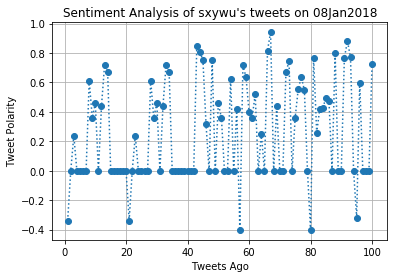

In [7]:
output = vader_tweets('@sxywu')
plot_sentiment(output,save=False)

In [52]:
output.sort_values(['Compound Score'],ascending = True)

,Compound Score,Negative Score,Neutral Score,Positive Score,Tweet,TweetsAgo,User
57,-0.4019,0.124,0.876,0.000,Soliciting advice: a month ago I paid for a br...,57.0,@sxywu
80,-0.4019,0.137,0.863,0.000,@Castillonis @NadiehBremer @DataToViz @Guardia...,80.0,@sxywu
1,-0.3384,0.107,0.893,0.000,PSA I’ve decided to dedicate the next few days...,1.0,@sxywu
21,-0.3384,0.107,0.893,0.000,PSA I’ve decided to dedicate the next few days...,21.0,@sxywu
95,-0.3182,0.223,0.777,0.000,@BenLesh @swyx It confuses me all the time too,95.0,@sxywu
87,0.0000,0.000,1.000,0.000,RT @alastairgee: Just some visualizations by @...,87.0,@sxywu
35,0.0000,0.000,1.000,0.000,@swyx @hj_chen @devfestasia omg swyx you're in...,35.0,@sxywu
36,0.0000,0.000,1.000,0.000,@ken_wheeler @ReactAmsterdam @ladyleet I've he...,36.0,@sxywu
37,0.0000,0.000,1.000,0.000,Wahoo! I'll be speaking at @ReactAmsterdam w/ ...,37.0,@sxywu
38,0.0000,0.000,1.000,0.000,@hj_chen NOOOOOO that’s the day I’ll be in the...,38.0,@sxywu
